Cargamos datos y vemos los datos disponibles

In [4]:
import pandas as pd

# Cargar los datos
file_path = './data/orders_orders.xlsx'  # Reemplaza con la ruta real
df = pd.read_excel(file_path)

# Asegurarse de que la columna de fecha sea de tipo datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Mostrar rango de fechas
min_date = df['Order Date'].min()
max_date = df['Order Date'].max()
print(f"Los datos están disponibles desde {min_date} hasta {max_date}")


Los datos están disponibles desde 2011-01-01 00:00:00 hasta 2014-12-31 00:00:00


Vemos la cifra anual real antes de separar entre train test para ver lo que daria año a año

In [5]:
# Agregar una columna de año-mes
df['Year-Month'] = df['Order Date'].dt.to_period('M')

# Agrupar por año-mes y sumar las ventas
monthly_sales = df.groupby('Year-Month')['Sales'].sum().reset_index()

# Convertir a formato datetime para análisis
monthly_sales['Year-Month'] = monthly_sales['Year-Month'].dt.to_timestamp()

# Separar los datos en train (2011-2013) y test (2014)
train = monthly_sales[(monthly_sales['Year-Month'] >= '2011-01-01') & (monthly_sales['Year-Month'] <= '2013-12-31')]
test = monthly_sales[(monthly_sales['Year-Month'] >= '2014-01-01') & (monthly_sales['Year-Month'] <= '2014-12-31')]

# Calcular ventas anuales para entender el comportamiento
print("Ventas anuales:")
print(monthly_sales.groupby(monthly_sales['Year-Month'].dt.year)['Sales'].sum())


Ventas anuales:
Year-Month
2011    2.259451e+06
2012    2.677439e+06
2013    3.405746e+06
2014    4.299866e+06
Name: Sales, dtype: float64


Visualización de la evolución de los datos de train mes a mes y viendo también tendencia, estacionalidad, etc

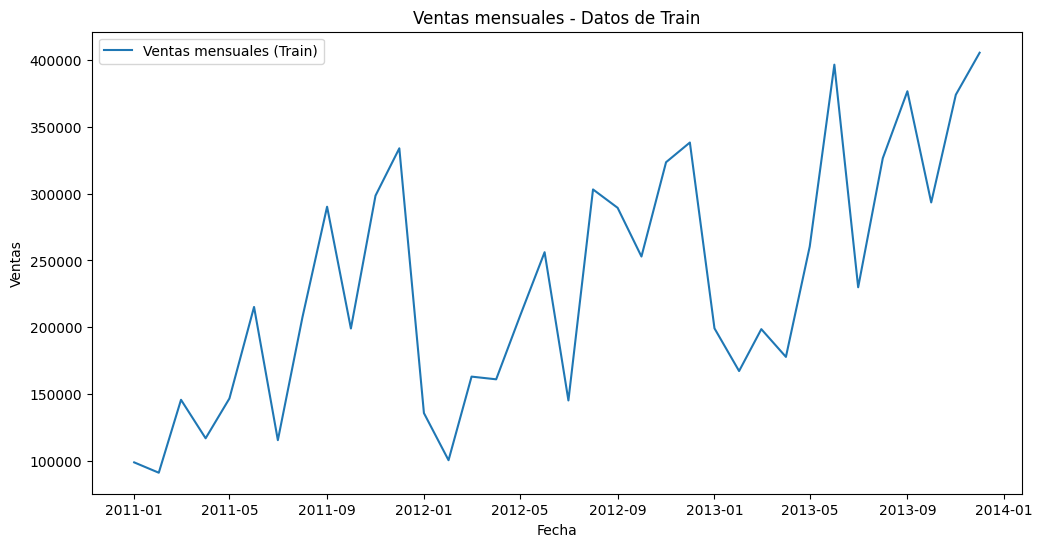

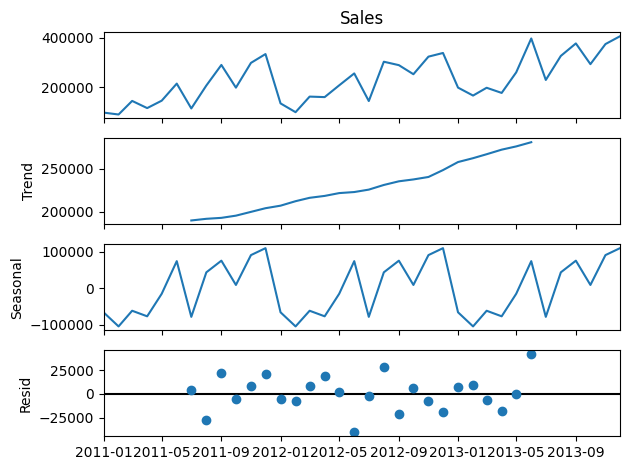

In [6]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Visualización de los datos de train
plt.figure(figsize=(12, 6))
plt.plot(train['Year-Month'], train['Sales'], label='Ventas mensuales (Train)')
plt.title('Ventas mensuales - Datos de Train')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

# Descomposición estacional
decomposition = seasonal_decompose(train.set_index('Year-Month')['Sales'], model='additive', period=12)
decomposition.plot()
plt.show()


Hacemos el test de adfuller 

In [7]:
from statsmodels.tsa.stattools import adfuller

# Prueba de estacionariedad
result = adfuller(train['Sales'])
print("Prueba de ADF:")
print(f"Estadístico ADF: {result[0]}")
print(f"p-valor: {result[1]}")
print("Valores críticos:")
for key, value in result[4].items():
    print(f"{key}: {value}")


Prueba de ADF:
Estadístico ADF: -2.22908992326923
p-valor: 0.1958573778732534
Valores críticos:
1%: -3.653519805908203
5%: -2.9572185644531253
10%: -2.6175881640625


In [8]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Configuración de modelos
def train_model(model_name, train_data, test_data):
    if model_name == 'ARIMA':
        model = ARIMA(train_data, order=(1, 1, 1)).fit()
    elif model_name == 'SARIMA':
        model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
    else:
        raise ValueError("Modelo no soportado")
    
    # Predicción para test
    forecast = model.forecast(steps=len(test_data))
    
    # Evaluación
    rmse = np.sqrt(mean_squared_error(test_data, forecast))
    mae = mean_absolute_error(test_data, forecast)
    return model, forecast, rmse, mae

# Preparación de datos
train_series = train.set_index('Year-Month')['Sales']
test_series = test.set_index('Year-Month')['Sales']

# Entrenar y evaluar modelos
arima_model, arima_forecast, arima_rmse, arima_mae = train_model('ARIMA', train_series, test_series)
sarima_model, sarima_forecast, sarima_rmse, sarima_mae = train_model('SARIMA', train_series, test_series)

print(f"ARIMA - RMSE: {arima_rmse}, MAE: {arima_mae}")
print(f"SARIMA - RMSE: {sarima_rmse}, MAE: {sarima_mae}")


c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Guillem\AppData\Local\Programs\Python\P

ARIMA - RMSE: 120513.20232249645, MAE: 112368.11723958224
SARIMA - RMSE: 77641.23921842626, MAE: 57152.090997892235


C:\Users\Guillem\AppData\Local\Temp\ipykernel_4532\3082597842.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range('2015-01-01', periods=12, freq='M'), sarima_forecast_2015, label='Predicción SARIMA (2015)', color='green')


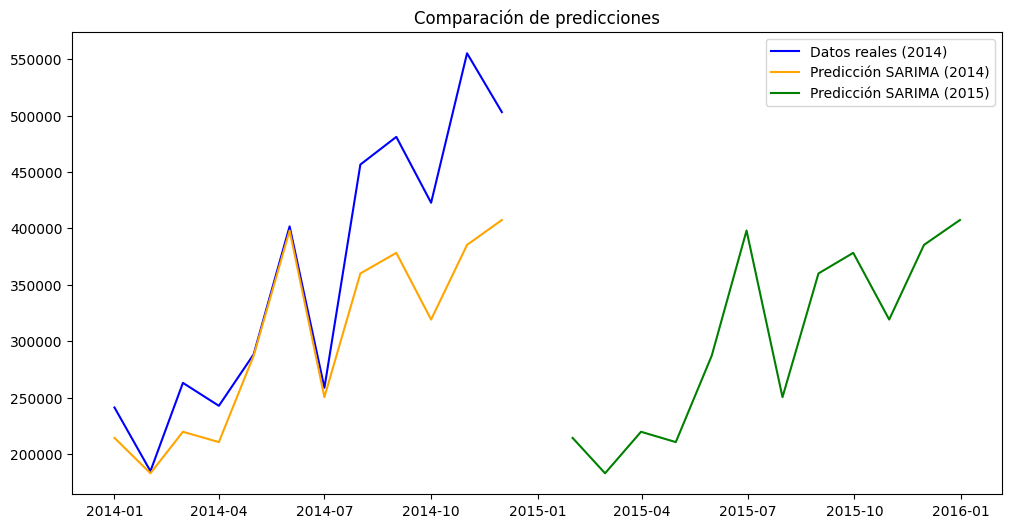

In [9]:
# Predicción para 2015 con SARIMA
sarima_forecast_2015 = sarima_model.forecast(steps=12)

# Comparación visual
plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series.values, label='Datos reales (2014)', color='blue')
plt.plot(test_series.index, sarima_forecast, label='Predicción SARIMA (2014)', color='orange')
plt.plot(pd.date_range('2015-01-01', periods=12, freq='M'), sarima_forecast_2015, label='Predicción SARIMA (2015)', color='green')
plt.title('Comparación de predicciones')
plt.legend()
plt.show()


C:\Users\Guillem\AppData\Local\Temp\ipykernel_4532\159850567.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range('2015-01-01', periods=12, freq='M'), sarima_forecast_2015, label='Predicción SARIMA (2015)', color='green', linestyle='-')  # Línea continua


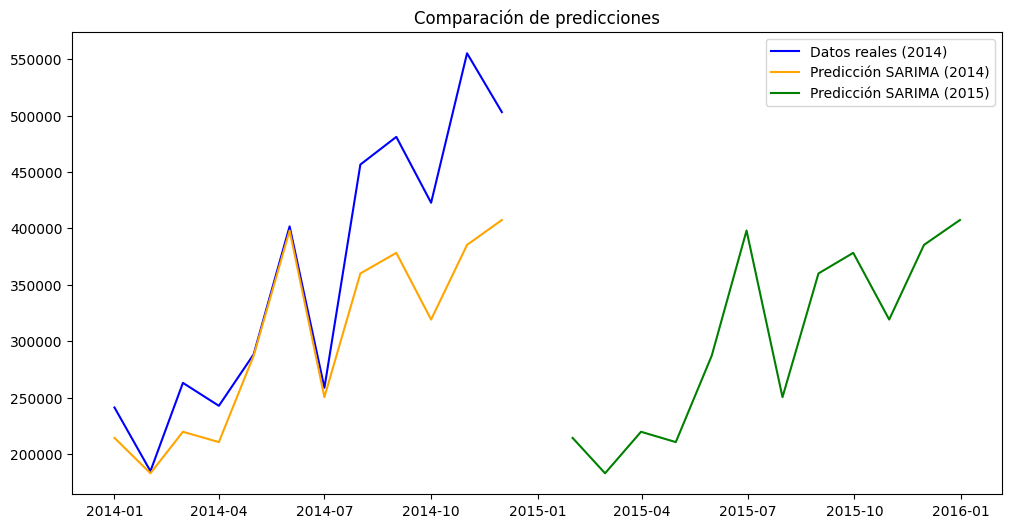

In [14]:
# Predicción para 2015 con SARIMA
sarima_forecast_2015 = sarima_model.forecast(steps=12)

# Comparación visual con líneas continuas
plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series.values, label='Datos reales (2014)', color='blue', linestyle='-')  # Línea continua
plt.plot(test_series.index, sarima_forecast, label='Predicción SARIMA (2014)', color='orange', linestyle='-')  # Línea continua
plt.plot(pd.date_range('2015-01-01', periods=12, freq='M'), sarima_forecast_2015, label='Predicción SARIMA (2015)', color='green', linestyle='-')  # Línea continua

plt.title('Comparación de predicciones')
plt.legend()
plt.show()



In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

# Definir rango de parámetros
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 12  # Periodo estacional
params = product(p, d, q, P, D, Q)
best_params = None
best_rmse = float('inf')

# Validación cruzada
for param in params:
    try:
        model = SARIMAX(train_series, order=(param[0], param[1], param[2]),
                        seasonal_order=(param[3], param[4], param[5], s)).fit()
        forecast = model.forecast(steps=len(test_series))
        rmse = np.sqrt(mean_squared_error(test_series, forecast))
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = param
    except:
        continue

print(f"Mejores parámetros: {best_params}, Mejor RMSE: {best_rmse}")


c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Guillem\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Guillem\AppData\Local\Programs\Python\P

Mejores parámetros: (1, 1, 1, 0, 1, 1), Mejor RMSE: 48181.86981716359
